# Data Loading and Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dython import nominal
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle

In [2]:
data_dir = './data/'

In [3]:
results_dir = './data/results/'

In [4]:
models_dir = './models/'

In [5]:
model_name = 'support_vector_regression'

In [6]:
regression_data = pd.read_csv(data_dir+'regression_data.csv', index_col=[0])

# SVM (Regression)

Sort the dataset so we can drop the date column

In [9]:
regression_data = regression_data.sort_values(by=['date', 'team', 'department']).reset_index(drop=True)

In [10]:
dep_var = ['targeted_productivity']

In [11]:
regression_data

,date,department,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,...,targeted_productivity_rmean_1_1,targeted_productivity_rmean_2_1,targeted_productivity_rmean_1_2,targeted_productivity_rmean_2_2,actual_productivity_lag_2,actual_productivity_lag_4,actual_productivity_rmean_2_1,actual_productivity_rmean_4_1,actual_productivity_rmean_2_2,actual_productivity_rmean_4_2
0,2015-01-01,finishing,1,0.75,3.94,0.0,960,0,0.0,0,...,0.00,0.00,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,2015-01-01,sweing,1,0.75,28.08,681.0,6900,45,0.0,0,...,0.75,0.00,0.375,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,2015-01-01,finishing,2,0.75,3.94,0.0,960,0,0.0,0,...,0.00,0.00,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,2015-01-01,sweing,2,0.75,19.88,733.0,6000,34,0.0,0,...,0.75,0.00,0.375,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,2015-01-01,sweing,3,0.75,28.08,795.0,6900,45,0.0,0,...,0.00,0.00,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,2015-03-11,sweing,10,0.75,21.81,1674.0,6000,34,0.0,0,...,0.70,0.75,0.725,0.725,0.7505,0.7000,0.7505,0.7000,0.6140,0.5710
1193,2015-03-11,finishing,11,0.80,2.90,0.0,2400,0,0.0,0,...,0.80,0.80,0.800,0.800,0.8000,0.9604,0.8000,0.9604,0.8000,0.8580
1194,2015-03-11,sweing,11,0.80,11.41,560.0,3420,50,0.0,0,...,0.80,0.80,0.800,0.800,0.7583,0.8000,0.7583,0.8000,0.7793,0.8800
1195,2015-03-11,finishing,12,0.80,4.60,0.0,2160,0,0.0,0,...,0.80,0.80,0.800,0.800,0.9200,0.9030,0.9200,0.9030,0.8604,0.8516


In [12]:
categorical = np.array(['department', 'team'])

In [13]:
continuous = np.setdiff1d(np.setdiff1d(regression_data.columns,categorical), dep_var)

In [14]:
continuous = continuous[continuous != 'date']

In [15]:
X = regression_data.loc[:,np.union1d(categorical, continuous)]

In [16]:
y = regression_data.loc[:,dep_var]*100

In [15]:
columns = ['task', 'model', 'split', 'C', 'kernel', 'gamma', 'epsilon', 'valid_mean_value', 'predicted_mean_value', 'percentage_difference', 'valid_rsq', 'valid_mae', 'valid_mse', 'valid_rmse']
support_vector_regression_results_df = pd.DataFrame(columns=columns)
df_rows = 0

Now we need to prepare our data and the cross-validation process so that we can start training. As we are dealing with time-series we need to split the data appropriately. We will use 20% of the data for testing.

In [17]:
test_idx = int((0.2*len(X)))

In [18]:
X_train, X_test, y_train, y_test = X.iloc[:len(X)- test_idx, :], X.iloc[len(X)- test_idx:, :], y.iloc[:len(y)- test_idx, :], y.iloc[len(y)- test_idx:, :]

In [61]:
pd.options.mode.chained_assignment = None  # default='warn'
# Cross-Validation Pipeline
print('Starting training')
# assign the tuned parameters
split = 0
Cs = [0.5, 5, 10, 15, 20, 25, 30]
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
gammas = ['scale', 'auto']
epsilons = [1, 0.1, 0.01, 0.001]
tscv = TimeSeriesSplit(n_splits=5)
for train_index, valid_index in tscv.split(X_train):
    # Data Split
    split += 1
    X_train_curr_split = X_train.iloc[train_index]
    X_valid_curr_split = X_train.iloc[valid_index]
    y_train_curr_split = y_train.iloc[train_index]
    y_valid_curr_split = y_train.iloc[valid_index]
    # Avoiding data leakage for input values
    # We need to encode only categorical variables
    enc = preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=100)
    X_train_curr_split.loc[:, categorical] = enc.fit_transform(X_train_curr_split[categorical])
    X_valid_curr_split.loc[:, categorical] = enc.transform(X_valid_curr_split[categorical])

    y_train_curr_split = y_train_curr_split.values.flatten()
    y_valid_curr_split = y_valid_curr_split.values.flatten()
    for C in Cs:
        for kernel in kernels:
            for gamma in gammas:
                for epsilon in epsilons:
                    model = SVR(C=C,
                                kernel=kernel,
                                gamma=gamma,
                                epsilon=epsilon,
                               )

                    pipe = make_pipeline(preprocessing.StandardScaler(), 
                                         model
                                            )
                    # train the model
                    pipe.fit(X_train_curr_split, y_train_curr_split)      
                    valid_predictions = pipe.predict(X_valid_curr_split)
                    # Obtain metric scores
                    valid_mae = mean_absolute_error(y_valid_curr_split, valid_predictions)
                    valid_mse = mean_squared_error(y_valid_curr_split, valid_predictions)
                    valid_rmse = mean_squared_error(y_valid_curr_split, valid_predictions, squared=False)
                    valid_rsq = r2_score(y_valid_curr_split, valid_predictions)
                    valid_mean_value = y_valid_curr_split.mean()
                    predicted_mean_value = valid_predictions.mean()
                    percetange_difference = ((y_valid_curr_split - valid_predictions)/(y_valid_curr_split)).mean()
                    support_vector_regression_results_df.loc[df_rows] = ['regression',
                                                                         'SVR',
                                                                         split,
                                                                         C,
                                                                         kernel,
                                                                         gamma,
                                                                         epsilon,
                                                                         valid_mean_value,
                                                                         predicted_mean_value,
                                                                         percetange_difference,
                                                                         valid_rsq,
                                                                         valid_mae,
                                                                         valid_mse,
                                                                         valid_rmse
                                                                         ]
                    # increment the rows variable
                    df_rows +=1
print('Done training')     

Starting training
Done training


## Functions

In [21]:
def group_seeded_data(data, groupby_columns, droped_cols=['seed', 'split']):
    grouped_data = data.groupby(groupby_columns).agg('mean').reset_index().drop(droped_cols, axis=1)
    return grouped_data

In [19]:
support_vector_regression_results_df

,task,model,split,C,kernel,gamma,epsilon,valid_mean_value,predicted_mean_value,percentage_difference,valid_rsq,valid_mae,valid_mse,valid_rmse
0,regression,SVR,1,0.5,linear,scale,1.000,73.364780,77.122068,-0.090290,0.092335,6.336570,126.301525,11.238395
1,regression,SVR,1,0.5,linear,scale,0.100,73.364780,78.042137,-0.103738,0.027989,6.259427,135.255233,11.629928
2,regression,SVR,1,0.5,linear,scale,0.010,73.364780,78.126834,-0.104913,0.021883,6.277153,136.104998,11.666405
3,regression,SVR,1,0.5,linear,scale,0.001,73.364780,78.088544,-0.104342,0.025630,6.268000,135.583572,11.644036
4,regression,SVR,1,0.5,linear,auto,1.000,73.364780,77.122068,-0.090290,0.092335,6.336570,126.301525,11.238395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115,regression,SVR,5,30.0,sigmoid,scale,0.001,73.144654,59.190648,0.139555,-123.801192,72.253560,8420.291677,91.762147
1116,regression,SVR,5,30.0,sigmoid,auto,1.000,73.144654,58.366897,0.151148,-124.664745,72.513962,8478.555255,92.079071
1117,regression,SVR,5,30.0,sigmoid,auto,0.100,73.144654,58.754096,0.145819,-123.496352,72.153425,8399.724198,91.650009
1118,regression,SVR,5,30.0,sigmoid,auto,0.010,73.144654,59.151022,0.140124,-123.772826,72.242348,8418.377777,91.751718


In [20]:
support_vector_regression_results_df.to_csv(results_dir + 'support_vector_regression_results_df.csv')

Aggregate the values so that we average the results for each split

In [24]:
grouped_support_vector_regression_results_df = group_seeded_data(support_vector_regression_results_df, 
                                                                 ['C', 'kernel','gamma', 'epsilon'],
                                                                 ['split']
                                                                )

In [25]:
grouped_support_vector_regression_results_df

,C,kernel,gamma,epsilon,valid_mean_value,predicted_mean_value,percentage_difference,valid_rsq,valid_mae,valid_mse,valid_rmse
0,0.5,linear,auto,0.001,72.41761,73.728943,-0.049677,0.064877,5.592276,102.773805,9.937988
1,0.5,linear,auto,0.010,72.41761,73.747793,-0.049945,0.066615,5.586554,102.578448,9.925052
2,0.5,linear,auto,0.100,72.41761,73.762580,-0.050208,0.066276,5.587580,102.442169,9.922919
3,0.5,linear,auto,1.000,72.41761,73.155055,-0.041292,0.117811,5.619191,96.704448,9.646327
4,0.5,linear,scale,0.001,72.41761,73.728943,-0.049677,0.064877,5.592276,102.773805,9.937988
...,...,...,...,...,...,...,...,...,...,...,...
219,30.0,sigmoid,auto,1.000,72.41761,60.376971,0.147704,-68.857283,58.503712,7011.870937,77.427703
220,30.0,sigmoid,scale,0.001,72.41761,83.369022,-0.208615,-82.495076,68.293636,8634.578038,90.290265
221,30.0,sigmoid,scale,0.010,72.41761,83.366091,-0.208583,-82.496540,68.296017,8635.183121,90.294580
222,30.0,sigmoid,scale,0.100,72.41761,82.997084,-0.204684,-82.527679,68.428990,8643.052359,90.349703


In [65]:
grouped_support_vector_regression_results_df.to_csv(results_dir + 'grouped_support_vector_regression_results_df.csv')

## Functions

In [28]:
def plot_line(data, x_column = 'C', groupby_column = 'kernel', title='Line graph', title_size=25, axes_size=15, tick_size=12, acc = 'valid_mae'):
    grouped_data = data.groupby([groupby_column, x_column]).agg(acc=(acc, 'mean')).reset_index()
    
    fig, ax = plt.subplots(figsize=(10, 5))
    for feat in grouped_data[groupby_column].unique():
        feat_data = grouped_data[grouped_data[groupby_column]==feat].copy()
        X = feat_data[x_column]
        y = feat_data['acc'].copy()
        plt.plot(X, y, label=f'{groupby_column}_{feat}')
    
    acc_label = acc
    fig.legend(bbox_to_anchor=(0.9, 0.9))
    fig.suptitle(title + f' for {acc} change in regards to {x_column} for each value of {groupby_column}', fontsize=title_size,  y=1.02)
    ax.set_xlabel('C', fontsize=axes_size)
    ax.set_ylabel(f'{acc_label}'.capitalize(), fontsize=axes_size)
    ax.tick_params(axis='x', which='major', labelsize=tick_size)
    ax.tick_params(axis='y', which='major', labelsize=tick_size)
    plt.show()

In [29]:
def plot_difference(y_test, predictions_test, title='Scatter plot', title_size=25, axes_size=15, tick_size=12, acc = 'valid_accuracy'):
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.scatter(y_test, predictions_test)
    min_y = y_test.min()
    min_predictions = predictions_test.min()
    min_val = np.minimum(min_y, min_predictions)
    ax.axline((min_val, min_val), slope=1, color='black')   
    
    acc_label = acc.split('_')[0]
    fig.suptitle(title + f' for expected vs predicted output', fontsize=title_size,  y=1.02)
    ax.set_xlabel('Expected output', fontsize=axes_size)
    ax.set_ylabel('Predicted output', fontsize=axes_size)
    ax.tick_params(axis='x', which='major', labelsize=tick_size)
    ax.tick_params(axis='y', which='major', labelsize=tick_size)
    plt.show()

## Overal results demonstration

### MAE

#### kernel

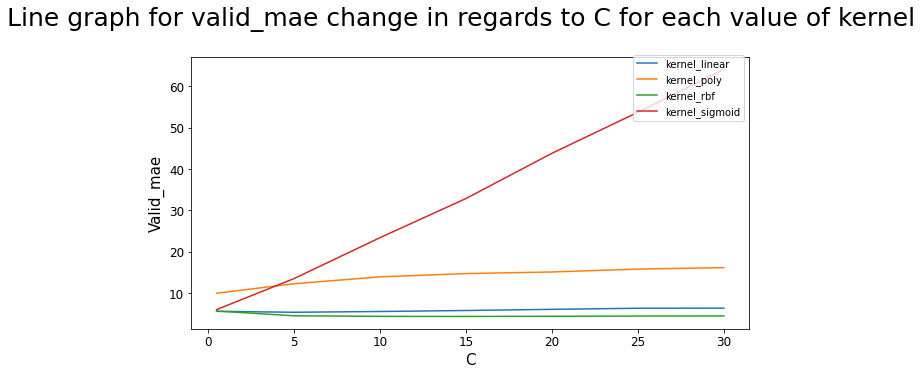

In [30]:
plot_line(grouped_support_vector_regression_results_df)

#### epsilon

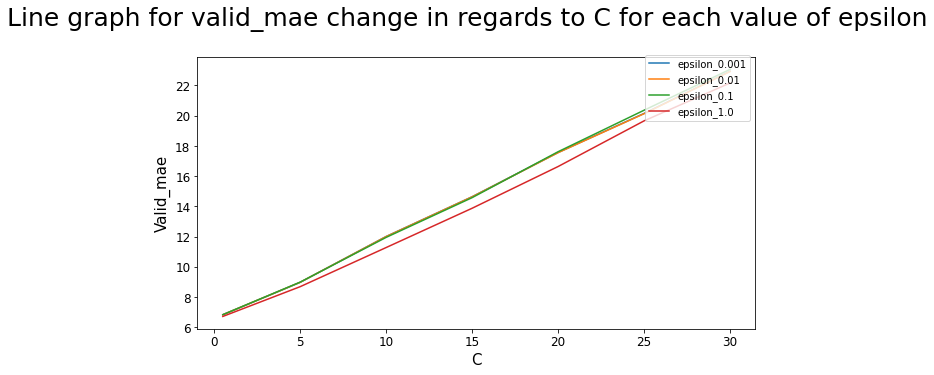

In [31]:
plot_line(grouped_support_vector_regression_results_df, groupby_column='epsilon')

#### gamma

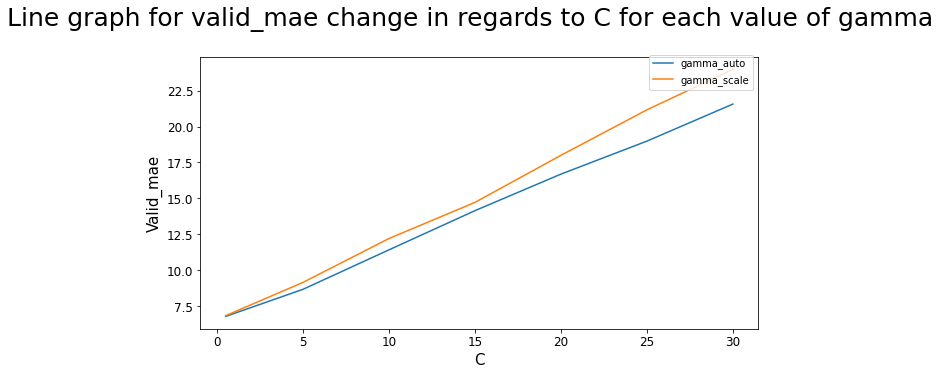

In [32]:
plot_line(grouped_support_vector_regression_results_df, groupby_column='gamma')

### MSE

#### kernel

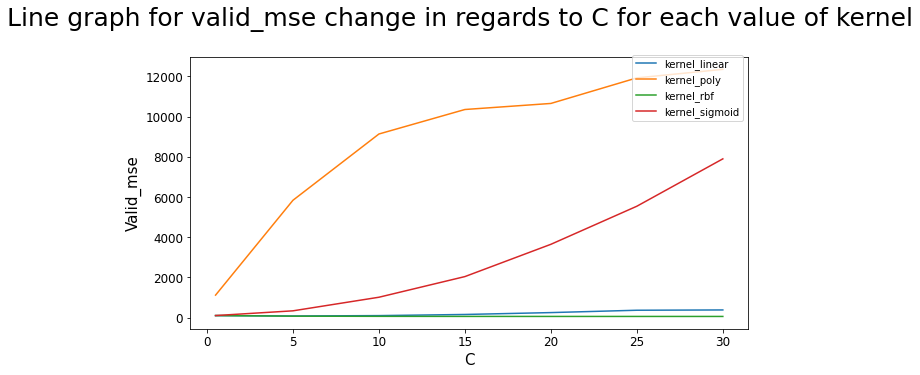

In [33]:
plot_line(grouped_support_vector_regression_results_df, acc='valid_mse')

#### epsilon

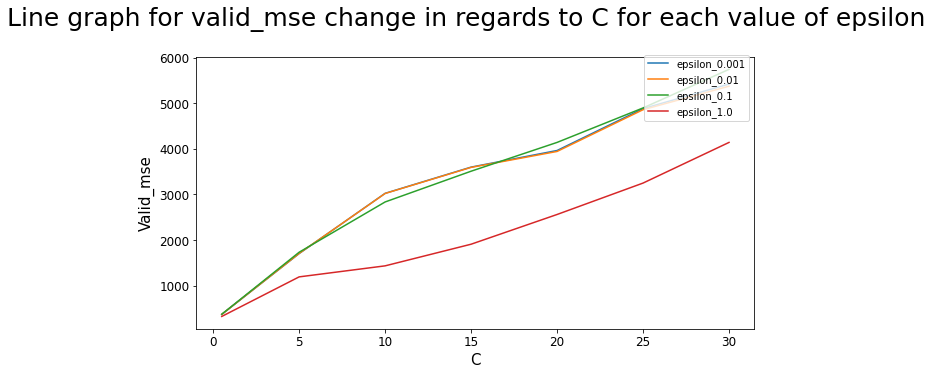

In [34]:
plot_line(grouped_support_vector_regression_results_df, groupby_column='epsilon', acc='valid_mse')

#### gamma

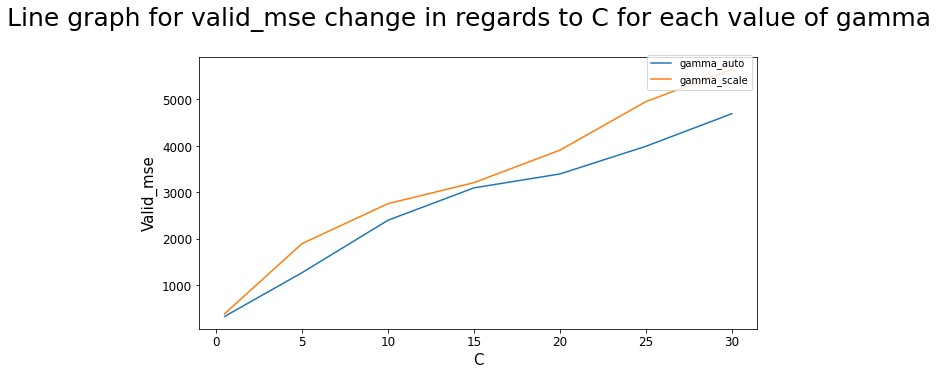

In [35]:
plot_line(grouped_support_vector_regression_results_df, groupby_column='gamma', acc='valid_mse')

From the above graphs it can be concluded the SVM models on this data works the best when the value of the C parameter is small. Also, it can be observed that the `poly` kernel does not work well with the data, `epsilon` and `gamma` values do not influence the output that much.

## Build best model

In [36]:
grouped_support_vector_regression_results_df[grouped_support_vector_regression_results_df['valid_rmse'] == grouped_support_vector_regression_results_df['valid_rmse'].min()]

,C,kernel,gamma,epsilon,valid_mean_value,predicted_mean_value,percentage_difference,valid_rsq,valid_mae,valid_mse,valid_rmse
215,30.0,rbf,scale,1.0,72.41761,72.129978,-0.022756,0.441912,4.665619,59.113038,7.623574


In [37]:
grouped_support_vector_regression_results_df[grouped_support_vector_regression_results_df['valid_mse'] == grouped_support_vector_regression_results_df['valid_mse'].min()]

,C,kernel,gamma,epsilon,valid_mean_value,predicted_mean_value,percentage_difference,valid_rsq,valid_mae,valid_mse,valid_rmse
215,30.0,rbf,scale,1.0,72.41761,72.129978,-0.022756,0.441912,4.665619,59.113038,7.623574


In [38]:
grouped_support_vector_regression_results_df[grouped_support_vector_regression_results_df['valid_mae'] == grouped_support_vector_regression_results_df['valid_mae'].min()]

,C,kernel,gamma,epsilon,valid_mean_value,predicted_mean_value,percentage_difference,valid_rsq,valid_mae,valid_mse,valid_rmse
112,15.0,rbf,auto,0.001,72.41761,73.198118,-0.040438,0.426827,4.269881,61.501675,7.766972


In [39]:
grouped_support_vector_regression_results_df[grouped_support_vector_regression_results_df['valid_rsq'] == grouped_support_vector_regression_results_df['valid_rsq'].max()]

,C,kernel,gamma,epsilon,valid_mean_value,predicted_mean_value,percentage_difference,valid_rsq,valid_mae,valid_mse,valid_rmse
215,30.0,rbf,scale,1.0,72.41761,72.129978,-0.022756,0.441912,4.665619,59.113038,7.623574


We have some conflicting values for the parameters. Given that we will choose the ones taht produce the lowest MAE.

In [7]:
model = SVR(C=30,
            kernel='rbf',
            gamma='auto',
            epsilon=0.001,
           )

best_pipe = make_pipeline(preprocessing.StandardScaler(), 
                          model
                          )

In [19]:
enc = preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=100)
X_train.loc[:, categorical] = enc.fit_transform(X_train[categorical])
X_test.loc[:, categorical] = enc.transform(X_test[categorical])

y_train_enc = y_train.values.flatten()
y_test_enc = y_test.values.flatten()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12412\2457187115.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:, categorical] = enc.fit_transform(X_train[categorical])
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12412\2457187115.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.loc[:, categorical] = enc.transform(X_test[categorical])


In [20]:
best_pipe.fit(X_train, y_train_enc)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=30, epsilon=0.001, gamma='auto'))])

Obtain metric scores

In [21]:
test_predictions = best_pipe.predict(X_test)
test_mae = mean_absolute_error(y_test_enc, test_predictions)
test_mse = mean_squared_error(y_test_enc, test_predictions)
test_rmse = mean_squared_error(y_test_enc, test_predictions, squared=False)
test_rsq = r2_score(y_test_enc, test_predictions)

### Results on test set

In [22]:
print(f"The MAE score on the test set for the best model is {test_mae.round(3)} \n")

The MAE score on the test set for the best model is 4.104 



In [23]:
print(f"The MSE score on the test set for the best model is {test_mse.round(3)} \n")

The MSE score on the test set for the best model is 45.508 



In [24]:
print(f"The RMSE score on the test set for the best model is {test_rmse.round(3)} \n")

The RMSE score on the test set for the best model is 6.746 



In [25]:
print(f"The Rsq score on the test set for the best model is {test_rsq.round(3)} \n")

The Rsq score on the test set for the best model is 0.43 



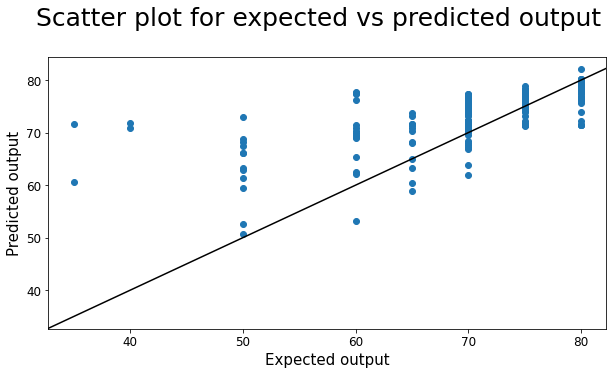

In [30]:
plot_difference(y_test_enc, test_predictions)

Save the model on disc

In [27]:
pickle.dump(best_pipe, open(models_dir+model_name, 'wb'))

Load the model from disk

In [28]:
loaded_best_pipe = pickle.load(open(models_dir+model_name, 'rb'))